<a href="https://colab.research.google.com/github/CRM48/AIML425-A1/blob/main/Assignmnt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/20, Train Loss: 0.2280, Val Loss: 0.1507
Epoch 2/20, Train Loss: 0.1100, Val Loss: 0.0793
Epoch 3/20, Train Loss: 0.0603, Val Loss: 0.0460
Epoch 4/20, Train Loss: 0.0376, Val Loss: 0.0320
Epoch 5/20, Train Loss: 0.0289, Val Loss: 0.0273
Epoch 6/20, Train Loss: 0.0260, Val Loss: 0.0258
Epoch 7/20, Train Loss: 0.0251, Val Loss: 0.0253
Epoch 8/20, Train Loss: 0.0247, Val Loss: 0.0250
Epoch 9/20, Train Loss: 0.0245, Val Loss: 0.0248
Epoch 10/20, Train Loss: 0.0242, Val Loss: 0.0246
Epoch 11/20, Train Loss: 0.0240, Val Loss: 0.0244
Epoch 12/20, Train Loss: 0.0238, Val Loss: 0.0242
Epoch 13/20, Train Loss: 0.0236, Val Loss: 0.0240
Epoch 14/20, Train Loss: 0.0234, Val Loss: 0.0238
Epoch 15/20, Train Loss: 0.0232, Val Loss: 0.0236
Epoch 16/20, Train Loss: 0.0230, Val Loss: 0.0234
Epoch 17/20, Train Loss: 0.0228, Val Loss: 0.0232
Epoch 18/20, Train Loss: 0.0226, Val Loss: 0.0230
Epoch 19/20, Train Loss: 0.0224, Val Loss: 0.0228
Epoch 20/20, Train Loss: 0.0222, Val Loss: 0.0226


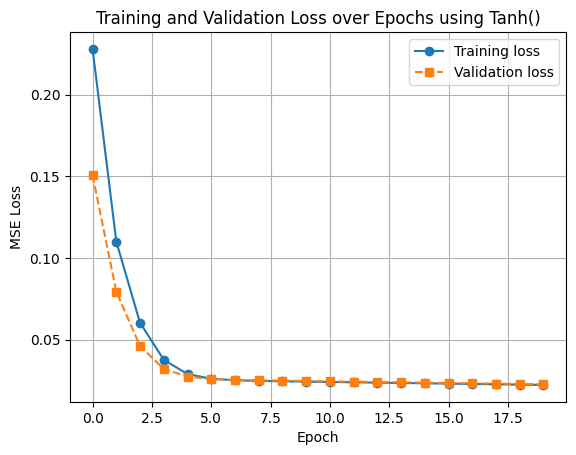

Test Loss (MSE): 0.0231


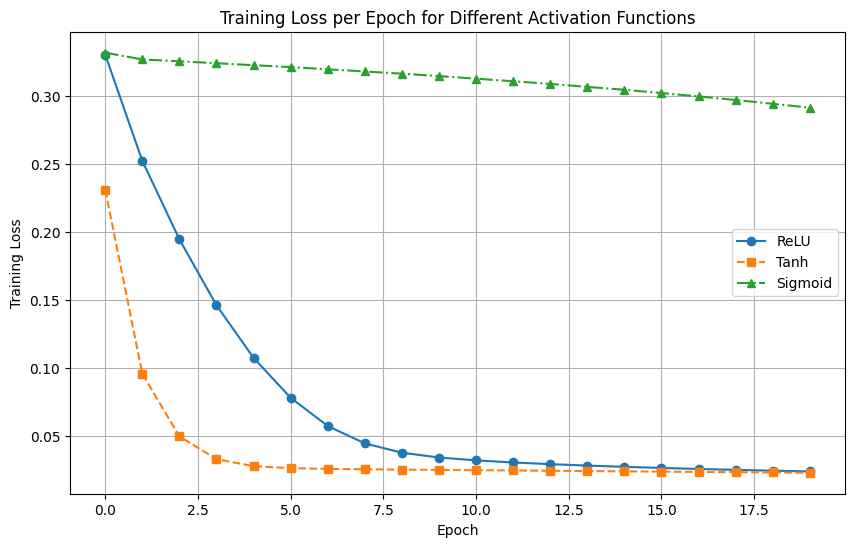

In [7]:
import sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Variables
seed = 1
num_inputs = 10000

train_percent = 0.7
validation_percent = 0.15
test_percent = 0.15

line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'x']

# Check ratio validity
if ((train_percent + validation_percent + test_percent) != 1.0):
    print("Ratio error in data splitting")
    sys.exit(1)

# Generate Data
np.random.seed(seed)
x = np.random.normal(0, 1, (num_inputs, 3))
norms = np.sqrt(np.sum(np.square(x), axis=1, keepdims=True))
y = x / norms

# Split Data
num_samples = x.shape[0]
num_train = int(train_percent * num_samples)
num_validation = int(validation_percent * num_samples)
num_test = int(test_percent * num_samples)

x_train = x[:num_train]
y_train = y[:num_train]

x_validation = x[num_train:num_train+num_validation]
y_validation = y[num_train:num_train+num_validation]

x_test = x[num_train+num_validation:]
y_test = y[num_train+num_validation:]

# 3D Interactive Plot (to display sphericality)
fig = go.Figure()

# Add training data output
fig.add_trace(go.Scatter3d(
    x=y_train[:, 0], y=y_train[:, 1], z=y_train[:, 2],
    mode='markers',
    marker=dict(size=3, color='blue'),
    name='Normalized y'
))

fig.update_layout(
    title="Input data normalised so length from origin = 1",
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data')
)

#fig.show()


# Creating the Datasets and DataLoaders

# Custom Dataset
class InputsDataset(Dataset):
  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

# Create training and validation datasets and dataloaders
batch_size = 64

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_val_tensor = torch.tensor(x_validation, dtype=torch.float32)
y_val_tensor = torch.tensor(y_validation, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = InputsDataset(x_train_tensor, y_train_tensor)
val_dataset = InputsDataset(x_val_tensor, y_val_tensor)
test_dataset = InputsDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Creating The Model
class NNModel(nn.Module):
  def __init__(self, activation_function=nn.ReLU()):
    super(NNModel, self).__init__()
    self.net = nn.Sequential(
         nn.Linear(3, 20),
         activation_function,
         nn.Linear(20, 20),
         activation_function,
         nn.Linear(20, 3)
     )

  def forward(self, x):
    return self.net(x)


# Variables
learning_rate = 0.01
num_epochs = 20
train_losses, val_losses = [], []
activation_functions = {'ReLU': nn.ReLU(), 'Tanh': nn.Tanh(), 'Sigmoid': nn.Sigmoid()}
activation_function = list(activation_functions.values())[1] # Adjustable for testing
model = NNModel(activation_function)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Training the model

for epoch in range(num_epochs):
    # Train phase
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs) # Compute outputs
        loss = criterion(outputs, targets) # Calculate loss
        loss.backward() # Update Weights
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad(): # Keep weights unaffected
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Epoch stats
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Visualisation of Loss
plt.plot(train_losses, label="Training loss", linestyle=line_styles[0], marker=markers[0])
plt.plot(val_losses, label="Validation loss", linestyle=line_styles[1], marker=markers[1])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title(f"Training and Validation Loss over Epochs using {activation_function}")
plt.grid(True)
plt.show()

# Model on test data
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Visualisation of multiple activation functions

loss_curves = {}

for name, func in activation_functions.items():
  train_losses = []
  model = NNModel(func)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
  loss_curves[name] = train_losses

plt.figure(figsize=(10, 6))

for i, (name, losses) in enumerate(loss_curves.items()):
    style = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(losses, label=name, linestyle=style, marker=marker)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch for Different Activation Functions")
plt.legend()
plt.grid(True)
plt.show()


